Extending from our [notebook on the math and intuition behind the Cox Model](https://napsterinblue.github.io/notes/stats/survival_analysis/cox_math/) let's do a practical example using real data.

### The Data

We'll use the [Telco Customer Churn dataset on Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn), which is basically a bunch of client records for a telecom company, where the goal is to predict churn (`Churn`) and the duration it takes for churn to happen (`tenure`).

In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Lot of potentially-useful information here, [this notebook](https://www.kaggle.com/jsaguiar/exploratory-analysis-with-seaborn) does a particularly good job exploring the data.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/'
                 'treselle-systems/customer_churn_analysis/'
                 'master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


There's about a 3-1 split between churn and not churn

In [3]:
df['Churn'].value_counts() / len(df)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

And the difference in `tenure` distribution between the two is pretty stark-- lot of right-censored data in our `No` group.

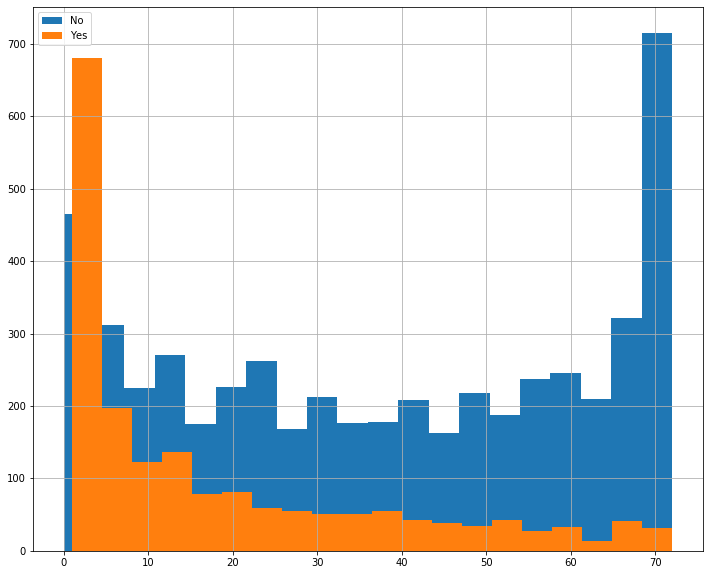

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))

for idx, group in df.groupby('Churn'):
    group['tenure'].hist(ax=ax, bins=20, label=idx)

ax.legend();

There's a lot more here than is illustrative to use, so let's pare down this dataset a bit.

First, we'll move `customerID` into the index as well as drop the `TotalCharges` variables, as there's an obvious, uninformative, colinearity between that and `tenure`.

In [5]:
simple = df.set_index('customerID', drop=True)
simple = simple.drop('TotalCharges', axis=1)

We'll keep the numeric `tenure` and `MonthlyCharges` columns, but here, I'm narrowing down to categorical features that I think might be useful, then dummy-ing them for model consumption.

In [6]:
simple = pd.get_dummies(simple,
                        columns=['gender', 'SeniorCitizen', 'InternetService',
                                 'Contract', 'PaymentMethod', 'Churn'],
                        drop_first=True).select_dtypes('number')

simple.head().T

customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
tenure,1.00,34.00,2.00,45.0,2.0
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
gender_Male,0.00,1.00,1.00,1.0,0.0
SeniorCitizen_1,0.00,0.00,0.00,0.0,0.0
InternetService_Fiber optic,0.00,0.00,0.00,0.0,1.0
InternetService_No,0.00,0.00,0.00,0.0,0.0
Contract_One year,0.00,1.00,0.00,1.0,0.0
Contract_Two year,0.00,0.00,0.00,0.0,0.0
PaymentMethod_Credit card (automatic),0.00,0.00,0.00,0.0,0.0
PaymentMethod_Electronic check,1.00,0.00,0.00,0.0,1.0


Printing some simple statistics, a few things stand out:

- The gender breakup is about 50/50
- About a third of the pop has DSL internet
- Over half of the userbase is going month-to-month

In [7]:
simple.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
gender_Male,7043.0,0.504756,0.500013,0.00,0.0,1.00,1.00,1.00
SeniorCitizen_1,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
InternetService_Fiber optic,7043.0,0.439585,0.496372,0.00,0.0,0.00,1.00,1.00
InternetService_No,7043.0,0.216669,0.412004,0.00,0.0,0.00,0.00,1.00
Contract_One year,7043.0,0.209144,0.406726,0.00,0.0,0.00,0.00,1.00
Contract_Two year,7043.0,0.240664,0.427517,0.00,0.0,0.00,0.00,1.00
PaymentMethod_Credit card (automatic),7043.0,0.216101,0.411613,0.00,0.0,0.00,0.00,1.00
PaymentMethod_Electronic check,7043.0,0.335794,0.472301,0.00,0.0,0.00,1.00,1.00


### Fitting a Model

So if we take what we've got and fit a simple model to it, we can get an easy glimpse at the significance of our features in the `p` column.

In [8]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(simple, 'tenure', 'Churn_Yes')

cph.print_summary()

I was negative-surprised to see that the `Electronic Check` and `Mailed Check` payment methods led to a significant dip in the Surival Curve-- me and my Planet Fitness membership are all too familiar with the "out of sight, out of mind" business model. `Credit card (automatic)`, on the other hand, is *not* significant, because the 4th payment method is `Bank transfer (automatic)`, which basically achieves the same thing

In [9]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

### Plotting
Of course, we can use the model and records from our dataset to predict the Survival Curve

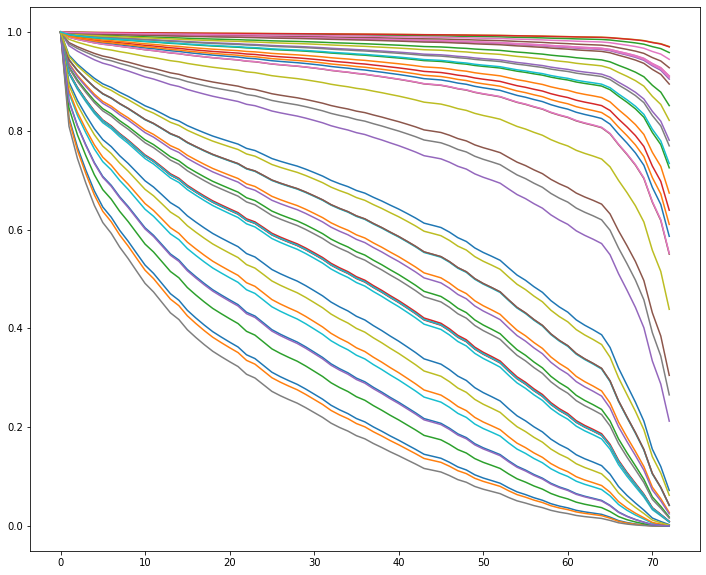

In [10]:
sample = simple.sample(50, random_state=12)

cph.predict_survival_function(sample).plot(figsize=(12, 10),
                                           legend=False);

Additionally, we can use `plot_covariate_groups()` to hold everything equal, save for one attribute, then examine the relative effects of different values on the population.

Here, we can see that having fiber internet tends to make users churn faster.

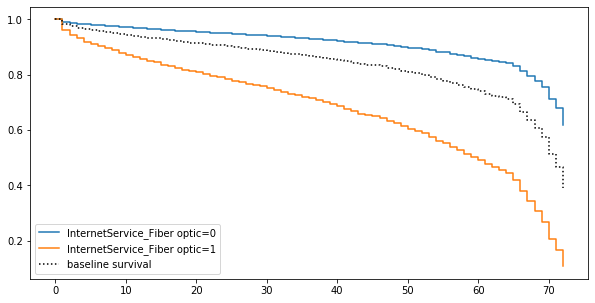

In [11]:
cph.plot_covariate_groups('InternetService_Fiber optic',
                          values=[0, 1],
                          figsize=(10, 5));

But why do you suppose that is?

### Comparing Two Populations

My immediate hypothesis is that it's got something to do with how the client has to pay. Indeed, at all levels of contract, someone with fiber internet pays more. So it could be a fiber thing, or could be a money thing.

In [12]:
simple.groupby(['Contract_Two year', 'Contract_One year',
                'InternetService_Fiber optic'])['MonthlyCharges'].agg(['mean', 'std'])

mean  \
Contract_Two year Contract_One year InternetService_Fiber optic               
0                 0                 0                             41.278220   
                                    1                             87.021194   
                  1                 0                             45.582923   
                                    1                             98.779499   
1                 0                 0                             45.927883   
                                    1                            104.571445   

                                                                       std  
Contract_Two year Contract_One year InternetService_Fiber optic             
0                 0                 0                            17.499133  
                                    1                            11.198021  
                  1                 0                            22.638256  
                                    1                             9.349157  
1                 0                 0                            26.633123  
                                    1                             9.422629

Let's pare down to just Fiber users to do some investigation.

In [13]:
fiber = simple[simple['InternetService_Fiber optic'] == 1]
fiber = fiber[['tenure', 'Contract_One year',
               'Contract_Two year', 'MonthlyCharges',
               'gender_Male', 'Churn_Yes']]

In [14]:
cph = CoxPHFitter().fit(fiber, 'tenure', 'Churn_Yes')

cph.print_summary()

Actually, it looks like having a higher monthly charge means you're *more* likely to stick around.

In [15]:
seed = 42

low = fiber[fiber['MonthlyCharges'] < 80].sample(50, random_state=seed)
hi = fiber[fiber['MonthlyCharges'] > 100].sample(50, random_state=seed)

Well that's odd.

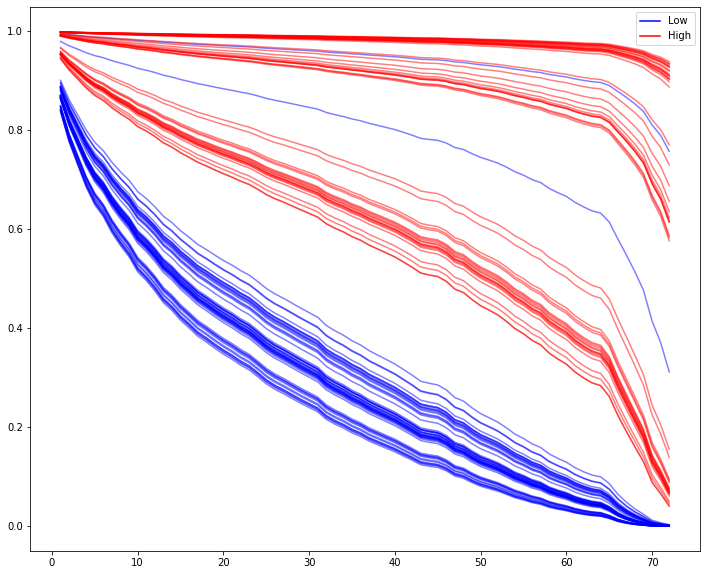

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))

cph.predict_survival_function(low).plot(ax=ax, c='b', alpha=.5, legend=False)
cph.predict_survival_function(hi).plot(ax=ax, c='r', alpha=.5, legend=False);

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b'),
                Line2D([0], [0], color='r')]

ax.legend(custom_lines, ['Low', 'High']);

It's obvious visually, but if we wanted to say with statistical confidence that the high and low paying populations had different survival curve distributions, we could do so via the built-in `logrank_test()`

In [17]:
from lifelines.statistics import logrank_test

results = logrank_test(low['tenure'], hi['tenure'],
                       event_observed_A=low['Churn_Yes'],
                       event_observed_B=hi['Churn_Yes'])
results.print_summary()

A-ha! Maybe it's the contracts that are holding people locked in. Let's just look at the half of people paying month-to-month

In [18]:
m2m = (fiber[(fiber['Contract_One year'] == 0)
             & (fiber['Contract_Two year'] == 0)]
      ).drop(['Contract_One year', 'Contract_Two year'], axis=1)

m2m.head()

,tenure,MonthlyCharges,gender_Male,Churn_Yes
customerID,,,,
9237-HQITU,2,70.70,0,1
9305-CDSKC,8,99.65,0,1
1452-KIOVK,22,89.10,1,0
7892-POOKP,28,104.80,0,1
0280-XJGEX,49,103.70,1,1


Re-fit and...

In [19]:
cph = CoxPHFitter()

cph.fit(m2m, duration_col='tenure', event_col='Churn_Yes')

cph.print_summary()

Damn it.

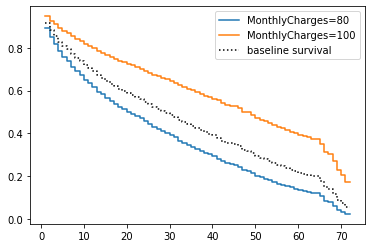

In [20]:
cph.plot_covariate_groups('MonthlyCharges', values=[80, 100])

### Starting Over

So there's obviously more at play here than just `MonthlyCharges`.

Let's re-pull our original dataset with all of the features, but only for records that are going month-to-month on Fiber internet

In [21]:
m2m_index = m2m.index

a = df.set_index('customerID')
b = a.loc[m2m_index].drop('TotalCharges', axis=1)
c = pd.get_dummies(b, drop_first=True)

m2m_wide = c

Of course, fitting the model with everything but the kitchen sink yields us more than we need.

In [22]:
cph = CoxPHFitter()
cph.fit(m2m_wide, duration_col='tenure', event_col='Churn_Yes')
cph.print_summary()

Visually inspecting that `p` column again, let's hold out all of the features that look significant and re-fit.

In [23]:
sig_cols = ['gender_Male', 'Partner_Yes', 'MultipleLines_Yes',
            'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
            'TechSupport_Yes', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check',
            'PaymentMethod_Mailed check']

cph = CoxPHFitter()
cph.fit(m2m_wide[sig_cols + ['tenure', 'Churn_Yes']], duration_col='tenure', event_col='Churn_Yes')
cph.print_summary()

### Check Assumptions

This looks promising. But did we make a procedural blunder in all of our data transformation?

`lifelines` gives us an awesome tool that we can use to simply check the Cox Model assumptions

In [24]:
cph.check_assumptions(training_df=m2m_wide[sig_cols + ['tenure', 'Churn_Yes']])

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'MultipleLines_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['MultipleLines_Yes', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'DeviceProtection_Yes' failed the non-proportional test: p-value is 0.0129.

   Advice: with so few unique values (only 2), you can include `strata=['DeviceProtection_Yes',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'PaymentMethod_Mailed check' failed the non-proportional test: p-value is 0.0009.

   Advice: with so few unique values (only 2), you can include `strata=['PaymentMethod_Mailed
check', ...]` in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-str

Those last 3 points -- `1., 2., 3.` all suggest we try stratifying. But what is that?

### Stratifying

Recall the fundamental structure of our Proportional Hazard Model. Everything that we've been working with until now has been centered around finding the right fit for our partial hazard function.

However, we can additionally *stratify* our model to allow for *multiple* baseline hazard functions. This should track, intuitively, as we'd generally expect the *overall shape* of survival curves to vary between populations-- the linear scaling can only achieve so much, after all.

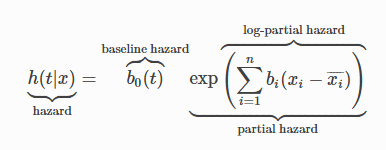

In [25]:
from IPython.display import Image
Image('images/lifelines_cox_eq.PNG')

And implementing it is as wasy as populating the `strata` argument

In [26]:
cph = CoxPHFitter()
cph.fit(m2m_wide[sig_cols + ['tenure', 'Churn_Yes']],
        duration_col='tenure', event_col='Churn_Yes',
        strata=['MultipleLines_Yes', 'DeviceProtection_Yes', 'PaymentMethod_Mailed check'])
cph.print_summary()

Re-checking, we can see that `lifelines` doesn't hate the work we did, this time~

In [27]:
cph.check_assumptions(m2m_wide[sig_cols + ['tenure', 'Churn_Yes']])

Proportional hazard assumption looks okay.


Of course, this now means that our visual interpretability goes down

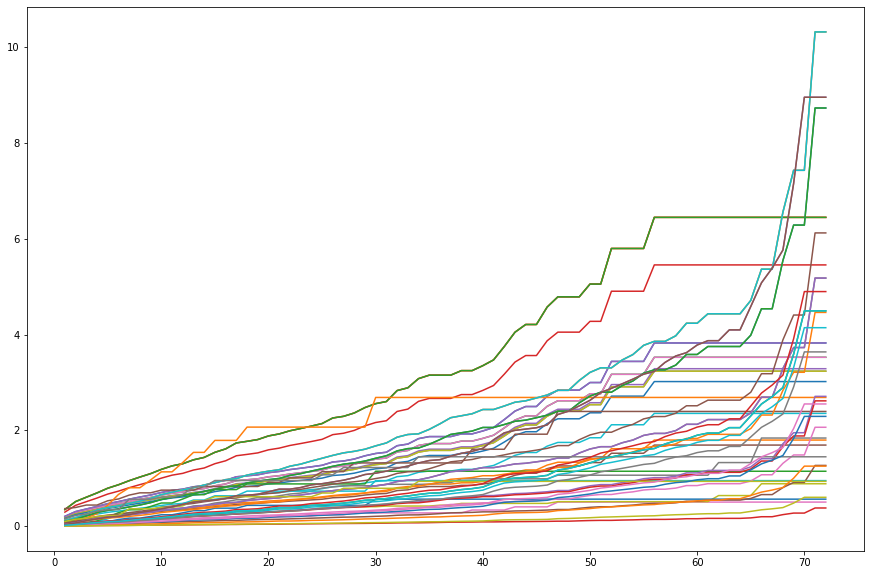

In [28]:
m2m_sample = m2m_wide[sig_cols + ['tenure', 'Churn_Yes']].sample(50)

cph.predict_cumulative_hazard(m2m_sample).plot(legend=False,
                                               figsize=(15, 10));

and while `lifelines` allows us to inspect the *baseline* survival curves, for the various strata

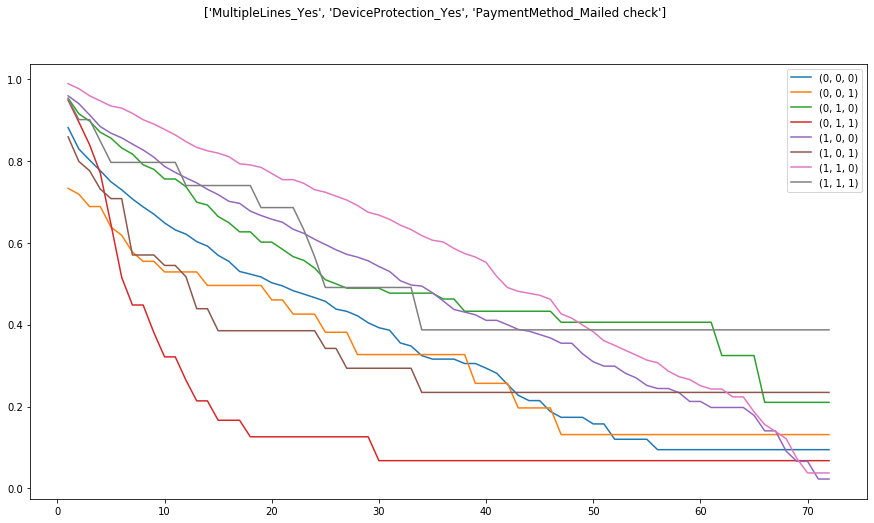

In [29]:
cph.baseline_survival_.plot(figsize=(15, 8))
plt.gcf().suptitle('{}'.format(cph.strata));

This gets us to the fundamental tension of "model accuracy" and "model interpretability" and is one of the many corners of "Data Science is more of an art than a science"